In [2]:
from Module_240106 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

 **Content of this Jupyter Notebook**:
 - Importing and selecting data
 - Chi2 fits
 - Unbinned Likelihood (UBLL) fits
 - Save figure named "filename.pdf"
 - Save statistics results to external txt file named "filename.pdf"
 - Calculate AIC from UBLL fits (minimising the negative log-likelihood using Minuit)
 - Calculate the weight factors to rank the models.
 
 **Notice:**
 
 I plot all bins regardless zero bins. However, I only perform chi2 fits to the non-zero bins.

In [3]:
# read csv file from main folder.
df_timedelays = pd.read_csv("../time_delay_diff_241021.csv")

# select cases with negative delay time differences.
dtau1 = select_data(df_timedelays, "GNEvGN", "KaaNG", 1.0)
dtau2 = select_data(df_timedelays, "GNEvGN", "KaaNG", 2.0)
dtau3 = select_data(df_timedelays, "GNEvGN", "KaaNG", 3.0)
dtau4 = select_data(df_timedelays, "GNEvGN", "KaaNG", 4.0)

In [13]:
double_gaussian

<function Module_240106.double_gaussian(x, w, sigma1, mu1, sigma2, mu2)>

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.22                      │              Nfcn = 252              │
│ EDM = 4.74e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

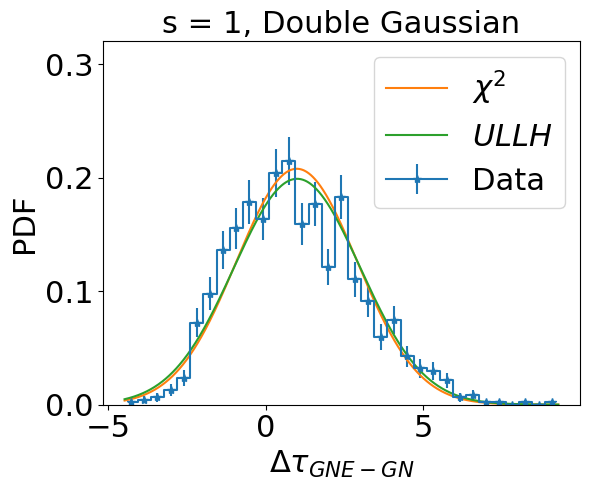

In [23]:
# before fitting
data = dtau1
title = "s = 1, Double Gaussian"
filename= "GNEvGN_KaaNG_s1_doublegaussian_240121" # network_parameter_scalefactor_fitmodel_date
savefig=False
fsize=22   # fontsize of ticklabels, legend
fsizeax=22 # fontsize of title, x-axis, y-axis

fit_statistics = [] # A. open list to append fit statistics

# 0. bin the data
y, bin_edges = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
x = 0.5 * (bin_edges[1:] + bin_edges[:-1])
yerr = np.sqrt(y)/np.sqrt(len(data)*np.diff(bin_edges)[0])

# 1. plot data
fig, ax = plt.subplots(figsize=(6,5))
ax.errorbar(x, y, yerr, marker='*', drawstyle="steps-mid", label="Data")

# 2. initial guess written as dict.
initial_guess = {"w":0.5, "sigma1": 2.0, "mu1": 1.0, "sigma2":2.0, "mu2":1.0}                      # EDIT: intial guesses
param_limits_dict = {"w":(0,1),
                     "sigma1": (0,None), "mu1": (None, None),
                     "sigma2": (0,None), "mu2": (None, None)
                    } # EDIT: bounds on params

# 3. filter out zero bins
non_zero_mask = y > 0
x = x[non_zero_mask]
y = y[non_zero_mask]
yerr = yerr[non_zero_mask]

# 4.1 chi2 fit
chi2 = Chi2Regression(double_gaussian, x, y, yerr)                     # EDIT: model
m = Minuit(chi2, **initial_guess)
m.errordef = 1.0
if param_limits_dict:
    for param, limits in param_limits_dict.items():
        m.limits[param]= limits
m.migrad()

# 5.1 plot the chi2 fit
fit_w, fit_sigma1, fit_mu1, fit_sigma2, fit_mu2 = m.values[:] # EDIT:params
xfit = np.linspace(min(data), max(data), 1000)
ax.plot(xfit, double_gaussian(xfit,
                       fit_w, fit_sigma1, fit_mu1, fit_sigma2, fit_mu2), label="$\chi^2$")   # EDIT: model

# 4.2 negative log-likelihood fit
nll = NegativeLogLikelihood(double_gaussian, data)                    # EDIt: model
m_nll = Minuit(nll, w=fit_w, sigma1=fit_sigma1, mu1=fit_mu1,
               sigma2=fit_sigma2, mu2=fit_mu2
              ) # use fit parameters from chi2-fit, EDIT: params
m_nll.errordef = Minuit.LIKELIHOOD
if param_limits_dict:
    for param, limits in param_limits_dict.items():
        m_nll.limits[param]= limits
#m_nll.limits["sigma2"]=(1.0,3.0)
#m_nll.limits["mu2"]=(0.5,None)
m_nll.migrad()

# 5.2 plot the ULLH fit
w_fit, sigma1_fit, mu1_fit, sigma2_fit, mu2_fit = m_nll.values[:]
ax.plot(xfit, double_gaussian(xfit, w_fit, sigma1_fit, mu1_fit, sigma2_fit, mu2_fit), label="$ULLH$")           # EDIT:params


# 6. figure adjustments
ax.tick_params(axis='both', which='major', labelsize=fsize)  # Change major tick labels
ax.set_title(f"{title}", fontsize=fsizeax)
ax.set_xlabel("$\Delta\\tau_{GNE-GN}$", fontsize=fsizeax)
ax.set_ylabel("PDF", fontsize=fsizeax)
ax.set_ylim(0.00,0.32)
ax.legend(fontsize=fsize)
plt.tight_layout()

# 7.1 save figure 
if savefig:
    plt.savefig(f"{filename}.pdf", dpi=600)
# 7.2 save fit statistics to a seperate file.
fit_statistics.append(f"Fit Statistics on system: {filename}")
fit_statistics.append("===============================================")
fit_statistics.append(" ")
fit_statistics.append("Initial Guesses:")
fit_statistics.append("==================")
for p, v in zip(initial_guess.keys(), initial_guess.values()):
    fit_statistics.append(f"{p}: {v}")
fit_statistics.append(" ")
fit_statistics.append("Chi2 fit Results:")
fit_statistics.append("==================")
fit_statistics.append(f"Limits:")
for name in m.parameters:
    fit_statistics.append(f"{name}: {m.limits[name]}")
fit_statistics.append(f"Chi2 = {m.fval}")
ndof = len(x)-m.nfit
fit_statistics.append(f"Ndof = {ndof}")
fit_statistics.append(f"P(Chi2, Ndof) = {stats.chi2.sf(m.fval,ndof)}")
fit_statistics.append(f"Fit parameter values:")
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_statistics.append(f'{p}: {v:.2f}  \u00B1 {e:.2f}')
fit_statistics.append(" ")
fit_statistics.append("Unbinned Log-Likelihood (UBLL) fit Results:")
fit_statistics.append("============================================")
fit_statistics.append(f"Limits:")
for name in m_nll.parameters:
    fit_statistics.append(f"{name}: {m_nll.limits[name]}")
fit_statistics.append(f"Max LL = {-m_nll.fval}")
fit_statistics.append(f"Fit parameter values:")
for p, v, e in zip(m_nll.parameters, m_nll.values, m_nll.errors):
    fit_statistics.append(f'{p}: {v:.2f}  \u00B1 {e:.2f}')
fit_statistics.append(" ")
fit_statistics.append("AIC and bias-corrected AIC")
fit_statistics.append("===========================")
fit_statistics.append(f"AIC = {AIC(nll=m_nll.fval, k=m_nll.nfit)}")
fit_statistics.append(f"AICc = {bias_corrected_AIC(nll=m_nll.fval,n=len(x), k=m_nll.nfit)}")
fit_statistics.append(" ")




joined_data = "\n".join(f"# {item}" for item in fit_statistics)

if savefig:
    with open(f"fit_statistics_{filename}.txt", "w") as file:
        file.write(joined_data)
        
# return the stats for easier adjust initial guesses.        
print(m)
print(m_nll)

Calculate weight factors between the gaussian and doubble gaussian AICc test results

In [8]:
p1 = weights_twomodels(x=4771, xmin=4779)
p2 = weights_twomodels(x=5366, xmin=5265)
p3 = weights_twomodels(x=5532, xmin=5315)
#p4 = weights_twomodels(x=8577, xmin=6296)

print(p1, p2, p3, p4)

0.9820137900379085 1.1698459177061964e-22 7.569177914366397e-48 0.0
